# L5. Differential Equations
This lecture note is heavily based on the [Quantitative Economics with Julia](https://julia.quantecon.org/intro.html) course in QuantEcon.

In this lecture, we will be modeling the dynamics of COVID-19 using ordinary differential equations (ODEs).

The model we will be seeing can be used to answer many important policy questions, such as:
1. Studying the impact of suppression through social distancing on the spread of the infection,
2. Determining the number of infections at a given time (which determines whether or not the health care system is overwhelmed),
3. How long the caseload can be deferred (hopefully until a vaccine arrives).

## 1. The SEIR Model
In the version of the SEIR model, all individuals in the population are assumed to be in one of four possible states: susceptible (S), exposed (E), infected (I) and removed (R). The flow across states always follows the path $S \to E \to I \to R$. 

Those in state R include people that have been infected and either recovered or died. Those who recover and live are assumed to have acquired lifetime immunity, although this can be relaxed (SEIRS model, which allows for $R \to S$ transition). Those in the exposed group are not yet infectious.

We will ignore birth and non-covid death during our time horizon, and assume a large, constant population. Because $N$ is large, we will approximate the number of individuals in each state by a continuum. Moreover, because it is constant, it is sufficient to keep track of the share of individuals in each state:
$$S(t) + E(t) + I(t) + R(t) = 1 \quad \text{for all } t.$$

The transitions between states are governed by the following Poisson rates:
- $\beta(t)$ is the _transmission rate_ or _effective contact rate_, the rate at which individuals are exposed to the virus: in an infinitesimal interval of time at $t$ of length $dt$, if the share of infected people is $I(t)$, the probability that a susceptible individual becomes exposed is $\beta(t) I(t) dt$
- $\sigma$ is the _infection rate_, the rate at which those exposed become infected
- $\gamma$ is the _recovery rate_, the rate at which infected people recover or die

Let $\dot{X}(t) = dX/dt$ denote the time derivative of a function $X(t)$. The SEIR model can then be written as:
\begin{align}
\dot{S}(t) & = -\beta(t) S(t) I(t) \\
\dot{E}(t) & = \beta(t) S(t) I(t) - \sigma E(t) \\
\dot{I}(t) & = \sigma E(t) - \gamma I(t) \\
\dot{R}(t) & = \gamma I(t)
\end{align}

(Notice that outflows and inflows from one state to another have to add up to 0, because the population is constant: $\dot{S}(t) + \dot{E}(t) + \dot{I}(t) + \dot{R}(t) = 0$.)

### 1.1. The Basic Reproduction Number
You will maybe have heard a lot in the news about the _basic reproduction number_. This is defined as $R_0(t) = \beta(t)/\gamma$ (despite the notation, it does not have anything to do with the share of the population in the removed state $R(t)$). The interpretation is the following:
- Individual transitions out of the infected state occur at a rate $\gamma$, so the expected time in the infected state is $1/\gamma$.
- Interactions occur at with a probability $\beta(t)$ at each interval, so an individual entering the infected state will transmit the virus to an average of $R_0(t) = \beta(t)/\gamma$ others

We will reparametrize the model in terms of $R_0(t)$ instead of $\beta(t)$ to be consistent with the notation in the epidemiology literature. Also, notice that we don't need to keep track of all the states: since $R(t) = 1 - S(t) - E(t) - I(t)$ we will drop $R(t)$.
\begin{align}
\dot{S}(t) & = -\gamma R_0(t) S(t) I(t) \\
\dot{E}(t) & = \gamma R_0(t) S(t) I(t) - \sigma E(t) \\
\dot{I}(t) & = \sigma E(t) - \gamma I(t)
\end{align}

Let's start with implementing the simplest version of the model, that assumes a constant $R_0$:

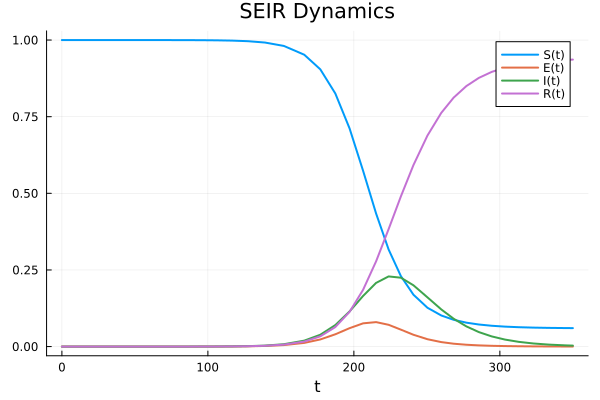

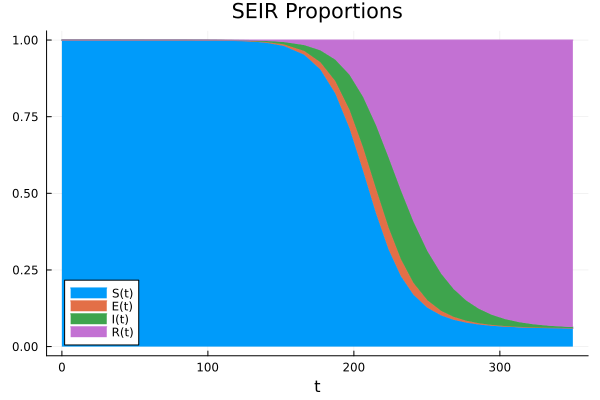

In [1]:
using DifferentialEquations, Plots

function F1!(du, u, p, t)
    
    #=Inputs
        - du : contains the derivatives (LHS of the equation). They will be modified in-place,
               i.e. you pass them as an argument to the function and the function returns that 
               argument after some modification. It is customary to denote that with a ! after
               the function name. Equation solvers usually benefit from a speed improvement in
               Julia when the equations are modified in-place by a function.
        - u : the variables (in our case, S(t), E(t) and I(t))
        - p : a tuple of parameters for the problem. Could be empty, but we could also use it to 
              declare γ, R₀ and σ
        - t : the time variable (u are functions of t themselves)
    
    Outputs
        - modified du=#
    
    γ, R₀, σ = p
    
    du[1] = -γ*R₀*u[1]*u[3]
    du[2] = γ*R₀*u[1]*u[3] - σ*u[2]
    du[3] = σ*u[2] - γ*u[3]
end

# Initial values:
I0 = 1e-7
E0 = 4.0*I0
S0 = 1.0 - I0 - E0
u0 = [S0, E0, I0]

# Parameters:
p = (γ = 1.0/18.0, R₀ = 3.0, σ = 1.0/5.2)

# Time span:
tspan = (0.0, 350.0) # 350 days

# Define an ODEProblem:
prob1 = ODEProblem(F1!, u0, tspan, p)

# Solve:
sol1 = solve(prob1, Tsit5())

# Plot the solution:
sol1_with_R = hcat(sol1[1,:], sol1[2,:], sol1[3,:], 1.0 .- sum(sol1, dims=1)')

gr()
display(plot(sol1.t, sol1_with_R, labels = ["S(t)" "E(t)" "I(t)" "R(t)"], title = "SEIR Dynamics", lw = 2, xlabel = "t"))

gr()
display(areaplot(sol1.t, sol1_with_R, labels = ["S(t)" "E(t)" "I(t)" "R(t)"], title = "SEIR Proportions", xlabel = "t"));

### 1.2. Extensions
Let's know consider some extensions that will allow us to conduct a policy experiment and keep track of some interesting variables:
1. We assume that the transmission rate follows a process with reversion to a value $\bar{R}_0$ which could be influenced by policy (e.g. through social distancing).
$$\dot{R}_0(t) = -\eta(R_0(t) - \bar{R}_0)$$

2. We will keep track of deaths too. To that end, let $\delta$ denote the mortality rate (among those leaving the infected state), which we assume to be constant. Then, the share of people dying evolves as:
$$\dot{D}(t) = \delta \gamma I(t).$$

We consider the policy experiment of reducing the stationary basic transmission rate $\bar{R}_0$ from 3 to 2.5, 2.0 or 1.5.

In [2]:
function F2!(du, u, p, t)
    
    #=Inputs
        - du : contains the derivatives (LHS of the equation). They will be modified in-place,
               i.e. you pass them as an argument to the function and the function returns that 
               argument after some modification. It is customary to denote that with a ! after
               the function name. Equation solvers usually benefit from a speed improvement in
               Julia when the equations are modified in-place by a function.
        - u : the variables (in our case, S(t), E(t), I(t), R₀(t), D(t))
        - p : a tuple of parameters for the problem
        - t : the time variable (u are functions of t themselves)
    
    Outputs
        - modified du=#
    
    γ, σ, η, δ, R̄₀ = p
    
    du[1] = -γ*u[4]*u[1]*u[3]
    du[2] = γ*u[4]*u[1]*u[3] - σ*u[2]
    du[3] = σ*u[2] - γ*u[3]
    du[4] = -η*(u[4] - R̄₀)
    du[5] = δ*γ*u[3]
end

# Initial values:
I0 = 1e-7
E0 = 4.0*I0
S0 = 1.0 - I0 - E0
R00 = 3.0
D0 = 0.0
u0 = [S0, E0, I0, R00, D0]

# Parameters:
p = (γ = 1.0/18.0, σ = 1.0/5.2, η = 1.0/20.0, δ = 0.01)
R̄₀_grid = [1.5, 2.0, 2.5, 3.0]

# Time span:
tspan = (0.0, 550.0) # 550 days

# Solve for different policy values:
experiments = [solve(ODEProblem(F2!, u0, tspan, merge(p, (R̄₀ = R, ))), Tsit5(), saveat = 0.5) for R in R̄₀_grid];

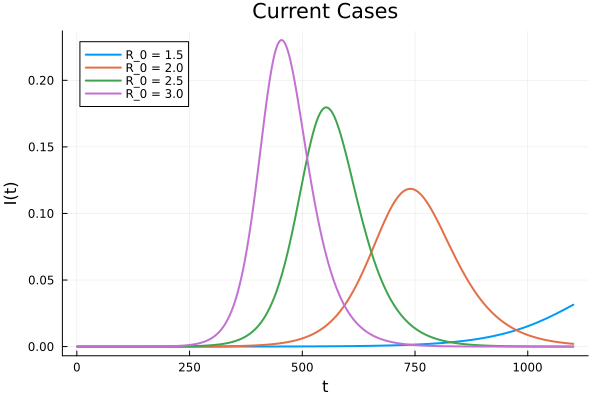

In [3]:
current_cases = [sol[3,:] for sol in experiments]
labels = permutedims(["R_0 = $r" for r in R̄₀_grid])

plot(current_cases, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "I(t)", title = "Current Cases")

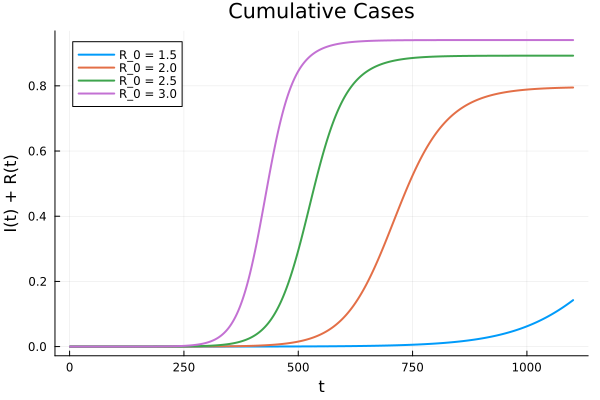

In [4]:
cumulative_cases = [1.0 .- sol[1,:] .- sol[2,:] for sol in experiments]

plot(cumulative_cases, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "I(t) + R(t)", title = "Cumulative Cases")

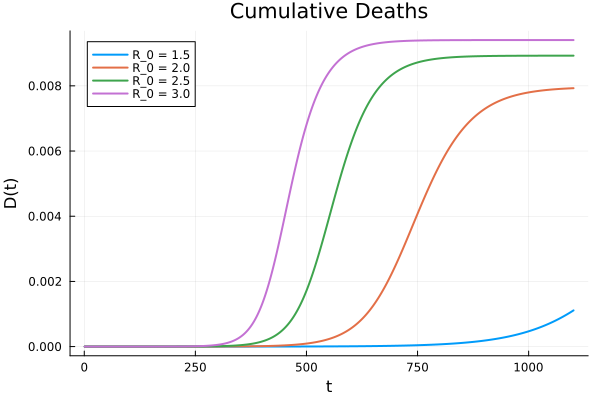

In [5]:
deaths = [sol[5,:] for sol in experiments]

plot(deaths, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "D(t)", title = "Cumulative Deaths")

As you can see, a reduction in $\bar{R}_0$ can greatly delay the viral outbreak. While outbreaks last longer (because it takes longer for people to get infected, and hence, either develop immunity or die, which reduces the pool of susceptible people), cumulative caseloads and deaths are also much smaller!

## 2 Methods for Solving ODEs
We choose ```Tsit5()``` as the solver option, which is the Tsitouras 5/4 Runge-Kutta methods. Let's learn more about what that is and how it works.

### 2.1. Finite-Difference Methods for Initial Value Problems
Finite-difference methods are frequently used to solve IVP of the type:
$$\dot{u}(t) = F(t, u), \quad u(t_0) = u_0.$$

Finite-difference methods specify a grid for the time span, $t_0 < t_1 < \cdots < t_n$, which could be, for example, equally-spaced with step-size $h$: $t_i = t_0 + ih, i = 1, \ldots, n$. The goal is to find, for each $i$, a $U_i$ that approximates $u(t_i)$. This can be done by constructing a difference equation on the grid, i.e. $U_{i+1} = G(U_i, U_{i-1}, \ldots, t_i, t_{i+1}, \ldots, t_n)$ and solving it sequentially, where $U_0 = u_0$ is given by the initial condition.

1. **Euler's method**: The simplest finite-difference scheme uses:
$$U_{i+1} = U_i + hF(t_i, U_i)$$

    From a Taylor approximation, it can be seen that, if $u$ is twice continuously differentiable, $u(t_{i+1}) = u(t_i) + h\dot{u}(t_i) + O(h^2)$. Moreover, under regularity conditions, the solution satisfies $u(t_i) - U_i = D(t_i) h + O(h^2)$ for some bounded $D(t)$, so it converges linearly in $h$.

2. **Trapezoid rule**: This approach uses the following update rule:
$$U_{i+1} = U_i + \frac{h}{2}[F(t_i, U_i) + F(t_{i+1}, U_{i+1})]$$
    (Notice that you have to solve for $U_{i+1}$, which appears on both sides.)

    A motivation for the use of this rule comes from the Fundamental Theorem of Calculus:
$$U_{i+1} - U_i = u(t_{i+1}) - u(t_i) = \int_{t_i}^{t_{i+1}}\dot{u}(t)dt,$$
    and the integral is approximated with the trapezoid quadrature rule.

3. **Runge-Kutta method**: The idea is to use a simple formula to see where the solution is going, but then check it and implement a correction when needed. 

    For example, we could start with the Euler approximation $U_{i+1}^E = U_i + hF(t_i, U_i)$, which uses the slope at $(t_i, U_i)$. Because this is based on the linear term of a Taylor approximation, it will tend to overshoot for concave $u(t)$ in that range (or undershoot if $u(t)$ is convex). If instead, we use the slope at $(t_i, U_{t+1}^E)$, we would end up at point $U_i + hF(t_i, U^E_{i+1})$, a point that would undershoot for concave $u(t)$ in that range (or overshoot otherwise).
    A first-order Runge-Kutta formula takes an average of these two estimates:
$$U_{i+1} = U_i + \frac{h}{2}[F(t_i, U_i) + F(t_{i+1}, U_i + h F(t_i, U_i))].$$

    These formula achieves quadratic rate of convergence $O(h^2)$ with only twice as many function evaluations. Further refinements are possible, such as the ```Tsit5()``` solver that we used, that can achieve even faster convergence.

    This is what 2nd and 4th order Runge-Kutta looks like:

![2nd and 4th Order Runge-Kutta](https://www.researchgate.net/profile/Muhammad-Fadlisyah/publication/265444798/figure/fig29/AS:669426277945349@1536615070399/The-Runge-Kutta-2nd-order-and-4th-order-methods.png "Runge-Kutta")

### 2.2. Shooting Methods for Boundary Value Problems
BVPs impose conditions on both the starting and the ending value of variables. Whereas IVP problems are easy to solve because the solution at each point depends only on initial conditions, BVP require methods that are global in nature. One example of BVP has the following structure:
\begin{align}
\dot{x}(t) &= F(x, y, t) \\
\dot{y}(t) &= G(x, y, t) \\
x(0) = x_0, &\quad y(T) = y_T
\end{align}

If we knew the starting value $y(0)$, then we would be able to solve the problem with IVP methods. Making a guess $y_0$ for $y(0)$, we can find the corresponding $y(T, y_0)$ (where we keep track of the dependence on $y_0$), and vary $y_0$ until $y(T, y_0) = y_T$. This is done in a two-layer process known as **shooting**:
1. Inner solver: For a given $y_0$, solve the IVP using any method of your choice (e.g. Runge-Kutta) and get $y(T, y_0)$
2. Outer solver: We want to solve the equation $y(T, y_0) = y_T$ with respect to $y_0$. For this, we can start with a guess for $y_0$ and pick the next iteration based on a non-linear equation-solving method (e.g. based on previous values or on the numerical derivatives of $y(T, y_0)$).

Another possibility is to do **reverse shooting**: in this case, we do the same as above, but guessing a value for the terminal conditions, and the equations are solved backwards in $t$.

This can be very useful in economics, since many models eventually converge to a steady state.

The next section has an example of a problem where reverse shooting can be applied: it is a continuous-time version of the cake eating problem we considered before.

## 3. Cake Eating in Continuous Time
A continuous-time version of the cake eating problem in L3 and L4 is as follows:
\begin{align*}
\max_{\{c(t)\}_{t=0}^\infty} & \int_{t=0}^\infty e^{-\rho t} u(c(t)) \\
\text{subj. to } & 0 \leq c(t) \leq x(t) \\ & \dot{x}(t) = - c(t) \\ & x(0) = x_0
\end{align*}

With $u(c) = \log(c)$, the FOCs for the Hamiltonian will be (I won't go into the details of the derivation, but if you're curious, this is example 7.3 in Acemoglu, 2008):
\begin{align*}
\frac{1}{c(t)} & = \lambda(t) \\
\dot{\lambda}(t) &= \rho \lambda(t) \\
\dot{x}(t) &= -c(t) 
\end{align*}

The "boundary conditions" in this case are two: the initial value $x(0) = x_0$ and the transversality condition $\lim_{t\to\infty}x(t) = 0$.

Let's get rid of the co-state variable $\lambda(t)$. One way to do that is to differentiate with respect to time in the first FOC, and replace it into the second one. Then the system will be:
\begin{align*}
\dot{c}(t) &= -\rho c(t) \\
\dot{x}(t) &= -c(t) 
\end{align*}

This is simple enough to solve by hand (the equations are separable). The solution is:
$$c(t) = \rho x_0 e^{-\rho t}, \quad x(t) = x_0 e^{-\rho t}.$$

Let's compare the solutions we get with **shooting** methods to the analytical solution:

  1.602245 seconds (6.35 M allocations: 423.288 MiB, 3.74% gc time, 99.88% compilation time: <1% of which was recompilation)
  0.000656 seconds (12.05 k allocations: 397.703 KiB)


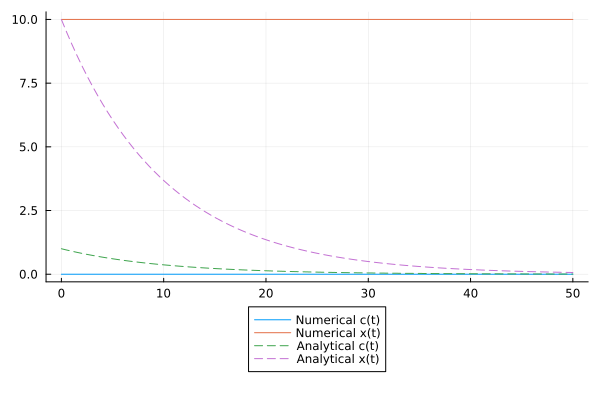

In [40]:
#=
Preliminary note:

DifferentialEquations does not handle boundary conditions at infinity.
Therefore, we are going to reparametrize our time variable:

τ = t/(1+t) <=> t = τ/(1-τ)

Notice that t -> 0 <=> τ -> 0 and t -> ∞ <=> τ -> 1

Consequenty, we have to modify our time derivatives (using the chain rule):

dy/dτ = dy/dt ⋅ dt/dτ = dy/dt / (1-τ)^2

for all variables y.
=#

function ODEs!(du, u, p, t)
    
    #= This function defines the system of ODEs. They always have the same structure:
    
    Inputs
        - du : contains the derivatives (LHS of the equation). They will be modified in-place,
               i.e. you pass them as an argument to the function and the function returns that 
               argument after some modification. It is customary to denote that with a ! after
               the function name. Equation solvers usually benefit from a speed improvement in
               Julia when the equations are modified in-place by a ̃on.
        - u : the variables (in our case, c(t) and x(t))
        - p : a tuple of parameters for the problem. Could be empty, but we could also use it to 
              declare ρ and x0
        - t : the time variable (u are functions of t themselves)
    
    Outputs
        - modified du
    =#
    
    ρ, x0 = p
    du[1] = - ρ * u[1] / (1.0 - t)^2
    du[2] = - u[1] / (1.0 - t)^2

end

function BC!(residual, u, p, t)
    
    #= This function defines the boundary conditions. They always have the same structure:
    
    Inputs
        - residual : what needs to equal 0 at the boundaries (it will become clear below).
        - u : the variables (in our case, c(t) and x(t))
        - p : a tuple of parameters for the problem. Could be empty, but we could also use it to 
              declare ρ
        - t : the time variable (u are functions of t themselves)
    
    Outputs
        - modified residual
    =#
    
    ρ, x0 = p
    residual[1] = u[1][2] - x0 # The second component of u should be x0 at the beginning of the period
    residual[2] = u[end][2] - 0.0 # The second component of u should be 0 at the end of the period
end

tspan = (0.0, 0.99) # Avoid 1.0 as it gives numerical instabilities

x0 = 10.0
ρ = 0.1
p = (ρ, x0)
u0 = [0.0, x0] # Starting values for the solver, could be constants or a function of t

problem = BVProblem(ODEs!, BC!, u0, tspan, p)
@time sol = solve(problem, Shooting(RK4())) # Shooting combined with Runge-Kutta method in inner solver
tscale(t::Float64) = t/(1.0+t)

tspan2 = (0.99, 0.0)
problem2 = BVProblem(ODEs!, BC!, u0, tspan2, p)
@time sol2 = solve(problem2, Shooting(RK4())) # Shooting backwards

plot(range(0, 50, 100), t -> sol.(tscale.(t))[1], label = "Numerical c(t)", legend = :outerbottom)
plot!(range(0, 50, 100), t -> sol.(tscale.(t))[2], label = "Numerical x(t)")
plot!(range(0, 50, 100), t -> ρ * x0 * exp.(-ρ * t), label = "Analytical c(t)", linestyle = :dash)
plot!(range(0, 50, 100), t -> x0 * exp.(-ρ * t), label = "Analytical x(t)", linestyle = :dash)

## Additional Resources
- Quantitative Economics with Julia: [Modeling COVID 19 with Differential Equations](https://julia.quantecon.org/continuous_time/seir_model.html). See also [Modeling Shocks in COVID 19 with Stochastic Differential Equations](https://julia.quantecon.org/continuous_time/covid_sde.html) for Stochastic Differential Equation (SDEs).

- Judd (1998) Chapter 10 and references therein.

- [Documentation](https://diffeq.sciml.ai/stable/) for ```DifferentialEquations.jl```.